In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [188]:
employee_df = pd.read_csv('../data/Employee_Attrition.csv')
employee_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [189]:
from sklearn.model_selection import train_test_split

# 데이터 준비
X = employee_df[['Age', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager']]
y = employee_df['Attrition'].map({'Yes': 1, 'No': 0}) # 라벨 인코딩
print(X.shape, y.shape) # (1470, 13) (1470,)
print('-----------------------')
print(len(X.columns)) # 13
print('-----------------------')
print(X.dtypes) # 'MaritalStatus', 'OverTime' -> object
print('-----------------------')
print(y.dtypes) # int64

# 범주형 변수 원-핫 인코딩 (첫 번째 카테고리 드랍해서 다중공선성 방지)
X_encoded = pd.get_dummies(X, columns=['MaritalStatus', 'OverTime'], drop_first=True)
print(X_encoded.shape)
X_encoded.head()

(1470, 13) (1470,)
-----------------------
13
-----------------------
Age                         int64
EnvironmentSatisfaction     int64
JobInvolvement              int64
JobLevel                    int64
JobSatisfaction             int64
MaritalStatus              object
MonthlyIncome               int64
OverTime                   object
StockOptionLevel            int64
TotalWorkingYears           int64
YearsAtCompany              int64
YearsInCurrentRole          int64
YearsWithCurrManager        int64
dtype: object
-----------------------
int64
(1470, 14)


,Age,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,StockOptionLevel,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,2,3,2,4,5993,0,8,6,4,5,False,True,True
1,49,3,2,2,2,5130,1,10,10,7,7,True,False,False
2,37,4,2,1,3,2090,0,7,0,0,0,False,True,True
3,33,4,3,1,3,2909,0,8,8,7,0,True,False,True
4,27,1,3,1,2,3468,1,6,2,2,2,True,False,False


In [190]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1176, 14) (1176,)
(294, 14) (294,)


In [191]:
from sklearn.preprocessing import StandardScaler

# 5. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)

In [192]:
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


# 모델 정의
models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', solver='saga', max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'MLP': MLPClassifier(max_iter=1000, random_state=42)
}

# GridSearchCV용 하이퍼파라미터
grid_params = {
    'LogisticRegression': {'C': [0.001, 0.1, 1, 10]},
    'DecisionTree': {'max_depth': [3, 5, None],
                     'min_samples_split': [2, 5]},
    'RandomForest': {'n_estimators': [50, 100],
                     'max_depth': [5, None]},
    'SVM': {'C': [0.1, 1],
            'kernel': ['linear', 'rbf']},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'XGBoost': {'n_estimators': [50, 100],
                'max_depth': [3, 5]},
    'MLP': {'hidden_layer_sizes': [(50,), (100,)],
            'alpha': [0.0001, 0.001],
            'max_iter': [1000],
            'early_stopping': [True]}
}

grid_results = {}

# 모델별 GridSearchCV + 평가
for name in models:
    print(f"\n🔍 {name} - GridSearchCV 실행 중...")
    grid = GridSearchCV(models[name], grid_params[name], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train_scaled_df, y_train)
    grid_best = grid.best_estimator_
    grid_pred = grid_best.predict(X_test_scaled_df)

    grid_results[name] = {
        'Best Params': grid.best_params_,
        'Accuracy': accuracy_score(y_test, grid_pred),
        'Precision': precision_score(y_test, grid_pred, zero_division=0),
        'Recall': recall_score(y_test, grid_pred),
        'F1 Score': f1_score(y_test, grid_pred)
    }

    print(f"▶ GridSearchCV 최적 파라미터: {grid.best_params_}")


🔍 LogisticRegression - GridSearchCV 실행 중...
▶ GridSearchCV 최적 파라미터: {'C': 10}

🔍 DecisionTree - GridSearchCV 실행 중...
▶ GridSearchCV 최적 파라미터: {'max_depth': 3, 'min_samples_split': 2}

🔍 RandomForest - GridSearchCV 실행 중...
▶ GridSearchCV 최적 파라미터: {'max_depth': 5, 'n_estimators': 50}

🔍 SVM - GridSearchCV 실행 중...
▶ GridSearchCV 최적 파라미터: {'C': 0.1, 'kernel': 'rbf'}

🔍 KNN - GridSearchCV 실행 중...
▶ GridSearchCV 최적 파라미터: {'n_neighbors': 3}

🔍 XGBoost - GridSearchCV 실행 중...
▶ GridSearchCV 최적 파라미터: {'max_depth': 5, 'n_estimators': 50}

🔍 MLP - GridSearchCV 실행 중...
▶ GridSearchCV 최적 파라미터: {'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'max_iter': 1000}


In [193]:
# RandomizedSearchCV용 하이퍼파라미터 (범위)
random_params = {
    'LogisticRegression': {'C': uniform(0.01, 10)},
    'DecisionTree': {'max_depth': randint(2, 10),
                     'min_samples_split': randint(2, 10)},
    'RandomForest': {'n_estimators': randint(50, 150),
                     'max_depth': randint(3, 10)},
    'SVM': {'C': uniform(0.1, 10),
            'kernel': ['linear', 'rbf']},
    'KNN': {'n_neighbors': randint(3, 10)},
    'XGBoost': {'n_estimators': randint(50, 150),
                'max_depth': randint(3, 10)},
    'MLP': {'hidden_layer_sizes': [(50,), (100,), (150,)],
            'alpha': uniform(0.0001, 0.01),
            'max_iter': [1000],
            'early_stopping': [True]}
}

random_results = {}

# 모델별 RandomizedSearchCV + 평가
for name in models:
    print(f"\n✅ {name} - RandomizedSearchCV 실행 중...")
    rand_search = RandomizedSearchCV(
        models[name],
        random_params[name],
        n_iter=20,  # 샘플 개수
        cv=5,
        scoring='f1',
        n_jobs=-1,
        random_state=42
    )

    # 데이터프레임 입력에 따라 적절한 데이터 사용
    # if name in ['LogisticRegression', 'SVM', 'MLP', 'KNN']: # 수치 스케일링 필수라서 스케일된 데이터 사용
    rand_search.fit(X_train_scaled_df, y_train)
    rand_pred = rand_search.predict(X_test_scaled_df)
    # else:
    #     rand_search.fit(X_train, y_train) # 스케일링 영향 적으니 원본 데이터 사용
    #     rand_pred = rand_search.predict(X_test)

    random_results[name] = {
        'Best Params': rand_search.best_params_,
        'Accuracy': accuracy_score(y_test, rand_pred),
        'Precision': precision_score(y_test, rand_pred, zero_division=0),
        'Recall': recall_score(y_test, rand_pred),
        'F1 Score': f1_score(y_test, rand_pred)
    }

    print(f"▶ {name} 최적 파라미터 (RandomizedSearchCV): {rand_search.best_params_}")


✅ LogisticRegression - RandomizedSearchCV 실행 중...
▶ LogisticRegression 최적 파라미터 (RandomizedSearchCV): {'C': np.float64(9.51714306409916)}

✅ DecisionTree - RandomizedSearchCV 실행 중...
▶ DecisionTree 최적 파라미터 (RandomizedSearchCV): {'max_depth': 3, 'min_samples_split': 9}

✅ RandomForest - RandomizedSearchCV 실행 중...
▶ RandomForest 최적 파라미터 (RandomizedSearchCV): {'max_depth': 6, 'n_estimators': 79}

✅ SVM - RandomizedSearchCV 실행 중...
▶ SVM 최적 파라미터 (RandomizedSearchCV): {'C': np.float64(1.4949386065204184), 'kernel': 'rbf'}

✅ KNN - RandomizedSearchCV 실행 중...
▶ KNN 최적 파라미터 (RandomizedSearchCV): {'n_neighbors': 5}

✅ XGBoost - RandomizedSearchCV 실행 중...
▶ XGBoost 최적 파라미터 (RandomizedSearchCV): {'max_depth': 6, 'n_estimators': 109}

✅ MLP - RandomizedSearchCV 실행 중...
▶ MLP 최적 파라미터 (RandomizedSearchCV): {'alpha': np.float64(0.0016599452033620266), 'early_stopping': True, 'hidden_layer_sizes': (150,), 'max_iter': 1000}


In [194]:
# GridSearch 결과
grid_summary = pd.DataFrame(grid_results).T.sort_values(by='F1 Score', ascending=False)
print("📊 GridSearchCV 결과:")
display(grid_summary)

# RandomizedSearch 결과
random_summary = pd.DataFrame(random_results).T.sort_values(by='F1 Score', ascending=False)
print("📊 RandomizedSearchCV 결과:")
display(random_summary)

📊 GridSearchCV 결과:


,Best Params,Accuracy,Precision,Recall,F1 Score
RandomForest,"{'max_depth': 5, 'n_estimators': 50}",0.8095,0.4237,0.5319,0.4717
LogisticRegression,{'C': 10},0.7211,0.3301,0.7234,0.4533
SVM,"{'C': 0.1, 'kernel': 'rbf'}",0.7347,0.3368,0.6809,0.4507
DecisionTree,"{'max_depth': 3, 'min_samples_split': 2}",0.7279,0.3226,0.6383,0.4286
KNN,{'n_neighbors': 3},0.8537,0.5769,0.3191,0.4110
XGBoost,"{'max_depth': 5, 'n_estimators': 50}",0.8333,0.4688,0.3191,0.3797
MLP,"{'alpha': 0.0001, 'early_stopping': True, 'hid...",0.8571,0.6923,0.1915,0.3000


📊 RandomizedSearchCV 결과:


,Best Params,Accuracy,Precision,Recall,F1 Score
LogisticRegression,{'C': 9.51714306409916},0.7211,0.3301,0.7234,0.4533
SVM,"{'C': 1.4949386065204184, 'kernel': 'rbf'}",0.7449,0.3444,0.6596,0.4526
RandomForest,"{'max_depth': 6, 'n_estimators': 79}",0.8197,0.4375,0.4468,0.4421
DecisionTree,"{'max_depth': 3, 'min_samples_split': 9}",0.7279,0.3226,0.6383,0.4286
KNN,{'n_neighbors': 5},0.8571,0.6190,0.2766,0.3824
XGBoost,"{'max_depth': 6, 'n_estimators': 109}",0.8163,0.3939,0.2766,0.3250
MLP,"{'alpha': 0.0016599452033620266, 'early_stoppi...",0.8605,0.7500,0.1915,0.3051


,Model,Search,Best Params,Accuracy,Precision,Recall,F1 Score
0,LogisticRegression,GridSearchCV,{'C': 10},0.7211,0.3301,0.7234,0.4533
1,DecisionTree,GridSearchCV,"{'max_depth': 3, 'min_samples_split': 2}",0.7279,0.3226,0.6383,0.4286
2,RandomForest,GridSearchCV,"{'max_depth': 5, 'n_estimators': 50}",0.8095,0.4237,0.5319,0.4717
3,SVM,GridSearchCV,"{'C': 0.1, 'kernel': 'rbf'}",0.7347,0.3368,0.6809,0.4507
4,KNN,GridSearchCV,{'n_neighbors': 3},0.8537,0.5769,0.3191,0.4110
5,XGBoost,GridSearchCV,"{'max_depth': 5, 'n_estimators': 50}",0.8333,0.4688,0.3191,0.3797
6,MLP,GridSearchCV,"{'alpha': 0.0001, 'early_stopping': True, 'hid...",0.8571,0.6923,0.1915,0.3000
7,LogisticRegression,RandomizedSearchCV,{'C': 9.51714306409916},0.7211,0.3301,0.7234,0.4533
8,DecisionTree,RandomizedSearchCV,"{'max_depth': 3, 'min_samples_split': 9}",0.7279,0.3226,0.6383,0.4286
9,RandomForest,RandomizedSearchCV,"{'max_depth': 6, 'n_estimators': 79}",0.8197,0.4375,0.4468,0.4421


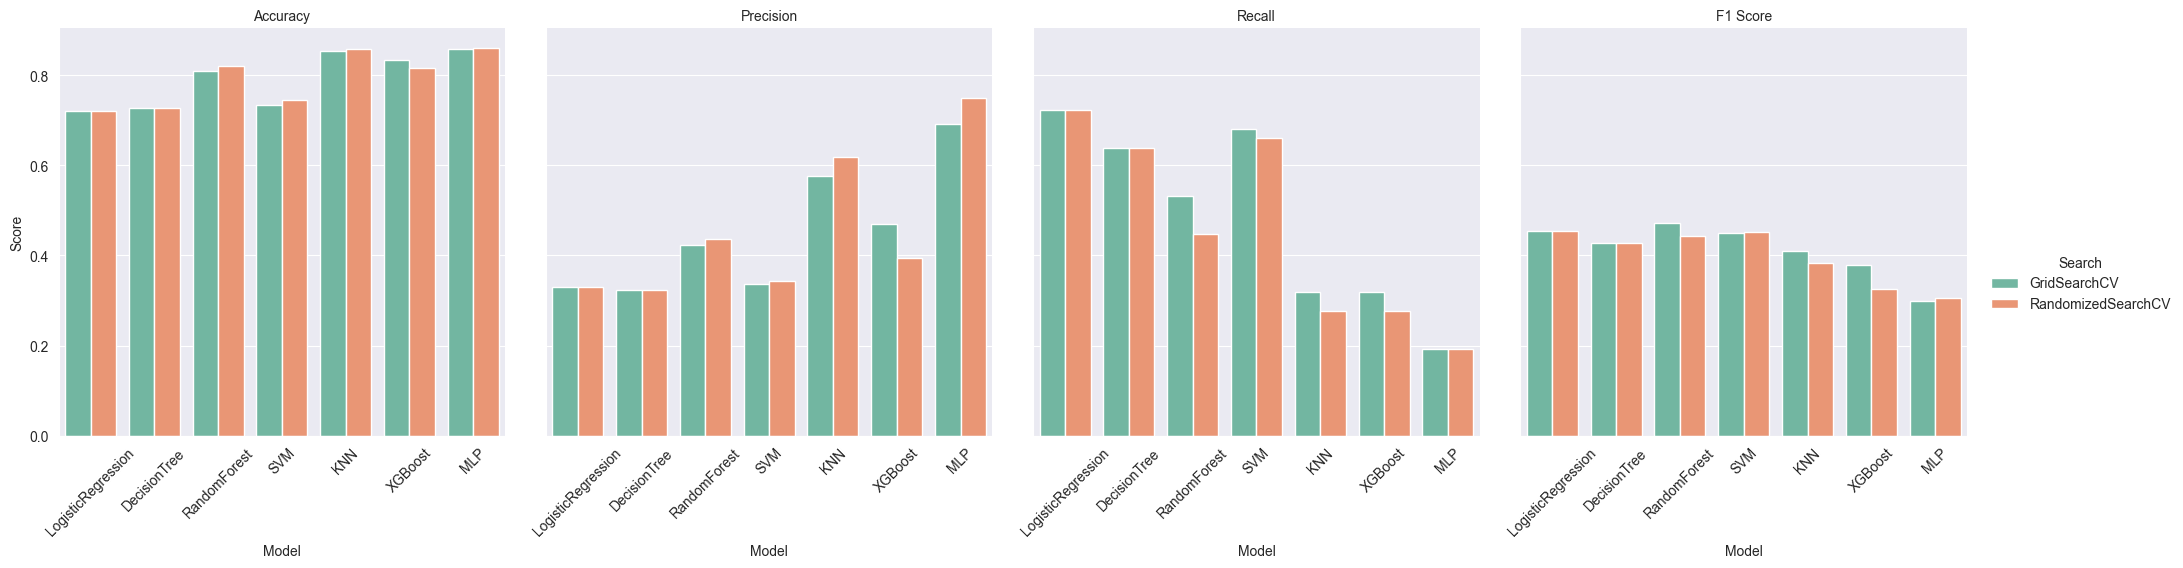

In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 결과 정리
grid_df = pd.DataFrame(grid_results).T
grid_df['Search'] = 'GridSearchCV'

random_df = pd.DataFrame(random_results).T
random_df['Search'] = 'RandomizedSearchCV'

# 하나로 합치기
result_df = pd.concat([grid_df, random_df])
result_df.reset_index(inplace=True)
result_df.rename(columns={'index': 'Model'}, inplace=True)

# 보기 좋게 정렬
result_df = result_df[['Model', 'Search', 'Best Params', 'Accuracy', 'Precision', 'Recall', 'F1 Score']]
display(result_df)

# 시각화를 위한 melt
melted = result_df.melt(id_vars=['Model', 'Search'],
                        value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                        var_name='Metric', value_name='Score')
# # 시각화
# plt.figure(figsize=(16, 8))
# sns.barplot(data=melted, x='Model', y='Score', hue='Search', palette='Set2', errorbar=None)
# plt.title('GridSearchCV vs RandomizedSearchCV', fontsize=16)
# plt.ylabel('Score')
# plt.xticks(rotation=45)
# plt.legend(title='Search Method')
# plt.grid(axis='y', linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()
#

g = sns.catplot(data=melted, x='Model', y='Score', hue='Search', col='Metric',
                kind='bar', palette='Set2', height=5, aspect=1)
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
plt.show()

In [196]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import pandas as pd

# VotingClassifier 구성 (Soft Voting)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(C=10, solver='saga', max_iter=1000, class_weight='balanced', random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=50, max_depth=5, class_weight='balanced', random_state=42)),
        ('xgb', XGBClassifier(n_estimators=50, max_depth=5, eval_metric='logloss', random_state=42))
    ],
    voting='soft'
)

# 학습
voting_clf.fit(X_train_scaled_df, y_train)

# 예측
y_pred = voting_clf.predict(X_test_scaled_df)

voting_result = {
    'Model': 'VotingClassifier',
    'Search': 'GridSearchCV',
    'Best Params': 'Soft Voting (lr(C=10), rf(n_estimators=50, max_depth=5), xgb(n_estimators=50, max_depth=5))',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred)
}

# RandomizedSearchCV 최적 파라미터로 VotingClassifier 구성
voting_clf_rand = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(C=9.51714306409916, solver='saga', max_iter=1000, class_weight='balanced', random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=79, max_depth=6, class_weight='balanced', random_state=42)),
        ('xgb', XGBClassifier(n_estimators=109, max_depth=6, eval_metric='logloss', random_state=42))
    ],
    voting='soft'
)

# 학습
voting_clf_rand.fit(X_train_scaled_df, y_train)

# 예측
y_pred_rand = voting_clf_rand.predict(X_test_scaled_df)

# 결과 딕셔너리 생성
voting_result_rand = {
    'Model': 'VotingClassifier',
    'Search': 'RandomizedSearchCV',
    'Best Params': 'Soft Voting (lr(C=9.517), rf(n_estimators=79, max_depth=6), xgb(n_estimators=109, max_depth=6))',
    'Accuracy': accuracy_score(y_test, y_pred_rand),
    'Precision': precision_score(y_test, y_pred_rand, zero_division=0),
    'Recall': recall_score(y_test, y_pred_rand),
    'F1 Score': f1_score(y_test, y_pred_rand)
}

In [197]:
# 기존 result_df에 VotingClassifier 추가
result_df = pd.concat([result_df, pd.DataFrame([voting_result, voting_result_rand])], ignore_index=True)
result_df = result_df[['Model', 'Search', 'Best Params', 'Accuracy', 'Precision', 'Recall', 'F1 Score']]
display(result_df)

,Model,Search,Best Params,Accuracy,Precision,Recall,F1 Score
0,LogisticRegression,GridSearchCV,{'C': 10},0.7211,0.3301,0.7234,0.4533
1,DecisionTree,GridSearchCV,"{'max_depth': 3, 'min_samples_split': 2}",0.7279,0.3226,0.6383,0.4286
2,RandomForest,GridSearchCV,"{'max_depth': 5, 'n_estimators': 50}",0.8095,0.4237,0.5319,0.4717
3,SVM,GridSearchCV,"{'C': 0.1, 'kernel': 'rbf'}",0.7347,0.3368,0.6809,0.4507
4,KNN,GridSearchCV,{'n_neighbors': 3},0.8537,0.5769,0.3191,0.4110
5,XGBoost,GridSearchCV,"{'max_depth': 5, 'n_estimators': 50}",0.8333,0.4688,0.3191,0.3797
6,MLP,GridSearchCV,"{'alpha': 0.0001, 'early_stopping': True, 'hid...",0.8571,0.6923,0.1915,0.3000
7,LogisticRegression,RandomizedSearchCV,{'C': 9.51714306409916},0.7211,0.3301,0.7234,0.4533
8,DecisionTree,RandomizedSearchCV,"{'max_depth': 3, 'min_samples_split': 9}",0.7279,0.3226,0.6383,0.4286
9,RandomForest,RandomizedSearchCV,"{'max_depth': 6, 'n_estimators': 79}",0.8197,0.4375,0.4468,0.4421


In [198]:
# 우선 지표들을 숫자로 변환
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    result_df[metric] = pd.to_numeric(result_df[metric], errors='coerce')

# 모델별로 Grid와 Random 중 성능이 더 좋은 걸 선택하는 함수
def select_best_by_metric(df, metric):
    best_rows = []
    for model in df['Model'].unique():
        subset = df[df['Model'] == model]
        best_row = subset.loc[subset[metric].idxmax()]
        best_rows.append(best_row)
    return pd.DataFrame(best_rows).sort_values(by=metric, ascending=False).reset_index(drop=True)

# 1. Accuracy 기준
print("🔹 Accuracy 기준으로 성능이 가장 좋은 결과 (내림차순):")
best_accuracy_df = select_best_by_metric(result_df, 'Accuracy')
display(best_accuracy_df[['Model', 'Search', 'Accuracy', 'Best Params']])
print()

# 2. Precision 기준
print("🔹 Precision 기준으로 성능이 가장 좋은 결과 (내림차순):")
best_precision_df = select_best_by_metric(result_df, 'Precision')
display(best_precision_df[['Model', 'Search', 'Precision', 'Best Params']])
print()

# 3. Recall 기준
print("🔹 Recall 기준으로 성능이 가장 좋은 결과 (내림차순):")
best_recall_df = select_best_by_metric(result_df, 'Recall')
display(best_recall_df[['Model', 'Search', 'Recall', 'Best Params']])
print()

# 4. F1 Score 기준
print("🔹 F1 Score 기준으로 성능이 가장 좋은 결과 (내림차순):")
best_f1_df = select_best_by_metric(result_df, 'F1 Score')
display(best_f1_df[['Model', 'Search', 'F1 Score', 'Best Params']])

🔹 Accuracy 기준으로 성능이 가장 좋은 결과 (내림차순):


,Model,Search,Accuracy,Best Params
0,MLP,RandomizedSearchCV,0.8605,"{'alpha': 0.0016599452033620266, 'early_stoppi..."
1,KNN,RandomizedSearchCV,0.8571,{'n_neighbors': 5}
2,VotingClassifier,RandomizedSearchCV,0.8367,"Soft Voting (lr(C=9.517), rf(n_estimators=79, ..."
3,XGBoost,GridSearchCV,0.8333,"{'max_depth': 5, 'n_estimators': 50}"
4,RandomForest,RandomizedSearchCV,0.8197,"{'max_depth': 6, 'n_estimators': 79}"
5,SVM,RandomizedSearchCV,0.7449,"{'C': 1.4949386065204184, 'kernel': 'rbf'}"
6,DecisionTree,GridSearchCV,0.7279,"{'max_depth': 3, 'min_samples_split': 2}"
7,LogisticRegression,GridSearchCV,0.7211,{'C': 10}



🔹 Precision 기준으로 성능이 가장 좋은 결과 (내림차순):


,Model,Search,Precision,Best Params
0,MLP,RandomizedSearchCV,0.7500,"{'alpha': 0.0016599452033620266, 'early_stoppi..."
1,KNN,RandomizedSearchCV,0.6190,{'n_neighbors': 5}
2,VotingClassifier,RandomizedSearchCV,0.4898,"Soft Voting (lr(C=9.517), rf(n_estimators=79, ..."
3,XGBoost,GridSearchCV,0.4688,"{'max_depth': 5, 'n_estimators': 50}"
4,RandomForest,RandomizedSearchCV,0.4375,"{'max_depth': 6, 'n_estimators': 79}"
5,SVM,RandomizedSearchCV,0.3444,"{'C': 1.4949386065204184, 'kernel': 'rbf'}"
6,LogisticRegression,GridSearchCV,0.3301,{'C': 10}
7,DecisionTree,GridSearchCV,0.3226,"{'max_depth': 3, 'min_samples_split': 2}"



🔹 Recall 기준으로 성능이 가장 좋은 결과 (내림차순):


,Model,Search,Recall,Best Params
0,LogisticRegression,GridSearchCV,0.7234,{'C': 10}
1,SVM,GridSearchCV,0.6809,"{'C': 0.1, 'kernel': 'rbf'}"
2,DecisionTree,GridSearchCV,0.6383,"{'max_depth': 3, 'min_samples_split': 2}"
3,RandomForest,GridSearchCV,0.5319,"{'max_depth': 5, 'n_estimators': 50}"
4,VotingClassifier,RandomizedSearchCV,0.5106,"Soft Voting (lr(C=9.517), rf(n_estimators=79, ..."
5,KNN,GridSearchCV,0.3191,{'n_neighbors': 3}
6,XGBoost,GridSearchCV,0.3191,"{'max_depth': 5, 'n_estimators': 50}"
7,MLP,GridSearchCV,0.1915,"{'alpha': 0.0001, 'early_stopping': True, 'hid..."



🔹 F1 Score 기준으로 성능이 가장 좋은 결과 (내림차순):


,Model,Search,F1 Score,Best Params
0,VotingClassifier,RandomizedSearchCV,0.5000,"Soft Voting (lr(C=9.517), rf(n_estimators=79, ..."
1,RandomForest,GridSearchCV,0.4717,"{'max_depth': 5, 'n_estimators': 50}"
2,LogisticRegression,GridSearchCV,0.4533,{'C': 10}
3,SVM,RandomizedSearchCV,0.4526,"{'C': 1.4949386065204184, 'kernel': 'rbf'}"
4,DecisionTree,GridSearchCV,0.4286,"{'max_depth': 3, 'min_samples_split': 2}"
5,KNN,GridSearchCV,0.4110,{'n_neighbors': 3}
6,XGBoost,GridSearchCV,0.3797,"{'max_depth': 5, 'n_estimators': 50}"
7,MLP,RandomizedSearchCV,0.3051,"{'alpha': 0.0016599452033620266, 'early_stoppi..."


In [111]:
!pip install imblearn

In [113]:
from imblearn.over_sampling import SMOTE

# SMOTE (Synthetic Minority Over-sampling Technique) 는 불균형한 데이터셋에서 소수 클래스(rare class)를 인위적으로 합성해서 샘플을 늘려줍니다.
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled_df, y_train)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced', random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=None, class_weight='balanced', random_state=42)),
        ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
    ],
    voting='soft'
)

voting_clf.fit(X_train_sm, y_train_sm)
y_pred = voting_clf.predict(X_test_scaled_df)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.90      0.90       247
           1       0.48      0.47      0.47        47

    accuracy                           0.83       294
   macro avg       0.69      0.69      0.69       294
weighted avg       0.83      0.83      0.83       294



In [118]:
# XGBoost scale_pos_weight 조정

from collections import Counter

# 훈련 데이터의 타겟 레이블(y_train)의 클래스별 샘플 개수 세기
counter = Counter(y_train)

number_of_majority_class_samples = max(counter.values())
number_of_minority_class_samples = min(counter.values())

print(f"다수 클래스 샘플 수: {number_of_majority_class_samples}")
print(f"소수 클래스 샘플 수: {number_of_minority_class_samples}")

scale_pos_weight = number_of_majority_class_samples / number_of_minority_class_samples
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

from xgboost import XGBClassifier

xgb = XGBClassifier(
    use_label_encoder=False,   # 최신 버전에서 불필요한 경고 제거용
    eval_metric='logloss',     # 평가 지표 설정
    scale_pos_weight=scale_pos_weight,  # 불균형 보정용 가중치
    random_state=42
)

# SMOTE 등으로 샘플링한 데이터나 원래 데이터로 학습
xgb.fit(X_train_scaled_df, y_train)  # 또는 X_train_sm, y_train_sm

# 예측
y_pred = xgb.predict(X_test_scaled_df)


from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

다수 클래스 샘플 수: 986
소수 클래스 샘플 수: 190
scale_pos_weight: 5.19
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       247
           1       0.42      0.40      0.41        47

    accuracy                           0.82       294
   macro avg       0.65      0.65      0.65       294
weighted avg       0.81      0.82      0.81       294



C:\Users\playdata\miniconda3\envs\ai_basic_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:29:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
